<a href="https://colab.research.google.com/github/tahereh-fahi/AI-ML-projects/blob/main/TabularQL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## How to use
- Run cells as you normally would.
- Use the explanation cells to understand what each line/block does.
- If a cell turns green but “does nothing”: it likely defines functions/classes, imports modules, or is guarded by `if __name__ == '__main__':`.




# RL — Home World (Tabular Q-Learning)


We **download** `framework.py` and `utils.py`

In [ ]:
import sys, subprocess
def _pip_install(pkg):
    try: __import__(pkg)
    except: subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])
for pkg in ["numpy", "matplotlib", "tqdm"]:
    _pip_install(pkg)
print("Environment OK")

Environment OK


In [ ]:
# --- RUN ME FIRST: download & prepare dataset(s) from GitHub Releases -------
import os, subprocess, hashlib, pathlib
import pandas as pd

os.makedirs("data", exist_ok=True)

def download(url: str, out_path: str):
    subprocess.run(["curl","-L","--fail","--retry","3","--retry-delay","3","-o",out_path,url], check=True)

def sha256sum(path: str) -> str:
    import hashlib; h = hashlib.sha256()
    with open(path,"rb") as f:
        for chunk in iter(lambda: f.read(1<<20), b""): h.update(chunk)
    return h.hexdigest()

def verify(path, expected_sha256):
    if not expected_sha256:
        return
    if sha256sum(path).lower() != expected_sha256.split(":")[-1].lower():
        raise RuntimeError("Checksum mismatch")

# Download main dataset
URL = "https://github.com/tahereh-fahi/Data/releases/download/v1.1.0/game.tsv"
OUT = "data/game.tsv"
SHA256 = "sha256:f59fc2d328ecbdcf8619508a8cf226974592e67293aa4a7b6ae4a1d0128b07b3"

download(URL, OUT)
verify(OUT, SHA256)
print("game.tsv ready")

# Display preview of the dataset
df = pd.read_csv(OUT, sep="\t", engine="python", header=None)
print("Preview of game.tsv (first 10 rows):")
display(df.head(10))  # Jupyter will show a nice table
# print(df.head(10).to_string())  # Terminal-friendly output

# Download supporting files
FILES = [
    ("https://github.com/tahereh-fahi/Data/releases/download/v1.1.0/framework.py", "framework.py", None),
    ("https://github.com/tahereh-fahi/Data/releases/download/v1.1.0/utils.py", "utils.py", None)
]
for url, out, sha in FILES:
    download(url, out)

print("framework.py and utils.py ready")


game.tsv ready
Preview of game.tsv (first 10 rows):


,0
0,"This room has a couch, chairs and TV."
1,You have entered the living room. You can watc...
2,"This room has two sofas, chairs and a chandelier."
3,A huge television that is great for watching g...
4,"This space has a swing, flowers and trees."
5,You have arrived at the garden. You can exerci...
6,"This area has plants, grass and rabbits."
7,A nice shiny bike that is fun to ride.
8,"This room has a fridge, oven, and a sink."
9,You have arrived in the kitchen. You can find ...


framework.py and utils.py ready


## agent tabular QL

Avg reward: -0.218606 | Ewma reward: -0.219371:  25%|▎| 50/200 [00:01<00:03, 42./tmp/ipython-input-2211038193.py:77: RuntimeWarning: overflow encountered in scalar multiply
  first_part = (1-ALPHA) * q_func[current_state_1, current_state_2, action_index,
/tmp/ipython-input-2211038193.py:86: RuntimeWarning: overflow encountered in scalar multiply
  second_part = ALPHA * (reward + GAMMA * maxQ)
/tmp/ipython-input-2211038193.py:90: RuntimeWarning: invalid value encountered in scalar add
  object_index] = first_part + second_part  # TODO Your update here
Avg reward: -0.193810 | Ewma reward: -0.184424: 100%|█| 200/200 [00:06<00:00, 32
Avg reward: -0.194600 | Ewma reward: -0.183499: 100%|█| 200/200 [00:07<00:00, 26
Avg reward: -0.193908 | Ewma reward: -0.181686: 100%|█| 200/200 [00:06<00:00, 32
Avg reward: -0.193861 | Ewma reward: -0.184256: 100%|█| 200/200 [00:06<00:00, 28
Avg reward: -0.195448 | Ewma reward: -0.182396: 100%|█| 200/200 [00:06<00:00, 32
Avg reward: -0.195171 | Ewma reward: -

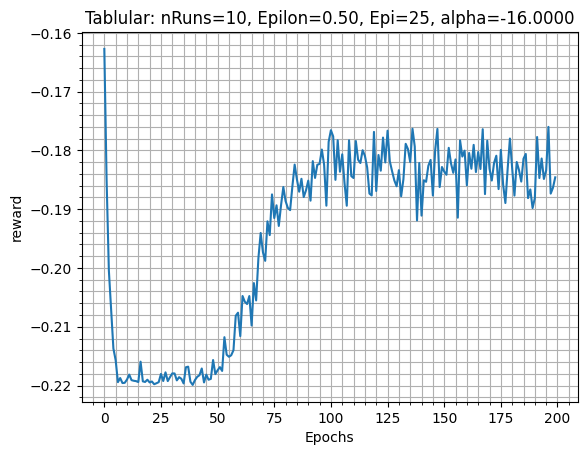

In [ ]:
"""Tabular QL agent"""
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import framework
import utils

DEBUG = False

GAMMA = 0.5  # discounted factor
TRAINING_EP = 0.5  # epsilon-greedy parameter for training
TESTING_EP = 0.05  # epsilon-greedy parameter for testing
NUM_RUNS = 10
NUM_EPOCHS = 200
NUM_EPIS_TRAIN = 25  # number of episodes for training at each epoch
NUM_EPIS_TEST = 50  # number of episodes for testing
ALPHA = 10^-6  # learning rate for training

ACTIONS = framework.get_actions()
OBJECTS = framework.get_objects()
NUM_ACTIONS = len(ACTIONS)
NUM_OBJECTS = len(OBJECTS)


# pragma: coderesponse template
# epsilon_greedy chooses an action–object pair randomly with probability ε, otherwise greedily selects the max-Q pair.
def epsilon_greedy(state_1, state_2, q_func, epsilon):
    """Returns an action selected by an epsilon-Greedy exploration policy

    Args:
        state_1, state_2 (int, int): two indices describing the current state
        q_func (np.ndarray): current Q-function
        epsilon (float): the probability of choosing a random command

    Returns:
        (int, int): the indices describing the action/object to take
    """
    p = np.random.random()

    if p<epsilon:
        action_index = np.random.randint(q_func.shape[2])
        object_index = np.random.randint(q_func.shape[3])
    else:
        Q_s_c = q_func[state_1, state_2, :, :]
        action_index, object_index = np.unravel_index(np.argmax(Q_s_c), Q_s_c.shape)



    return (action_index, object_index)


# pragma: coderesponse end


# pragma: coderesponse template
# tabular_q_learning updates the Q-table using the Bellman update rule with learning rate α and discount γ.
def tabular_q_learning(q_func, current_state_1, current_state_2, action_index,
                       object_index, reward, next_state_1, next_state_2,
                       terminal):
    """Update q_func for a given transition

    Args:
        q_func (np.ndarray): current Q-function
        current_state_1, current_state_2 (int, int): two indices describing the current state
        action_index (int): index of the current action
        object_index (int): index of the current object
        reward (float): the immediate reward the agent recieves from playing current command
        next_state_1, next_state_2 (int, int): two indices describing the next state
        terminal (bool): True if this episode is over

    Returns:
        None
    """



    first_part = (1-ALPHA) * q_func[current_state_1, current_state_2, action_index,
               object_index]

    if terminal :
        second_part = ALPHA * (reward)

    else :
        Q_sprim_cprim = q_func[next_state_1, next_state_2, :, :]
        maxQ = np.max(Q_sprim_cprim)
        second_part = ALPHA * (reward + GAMMA * maxQ)


    q_func[current_state_1, current_state_2, action_index,
           object_index] = first_part + second_part  # TODO Your update here

    return None  # This function shouldn't return anything


# pragma: coderesponse end


# pragma: coderesponse template
# run_episode executes one game episode: if training, it updates the Q-function; if testing, it computes cumulative discounted rewards.
def run_episode(for_training):
    """ Runs one episode
    If for training, update Q function
    If for testing, computes and return cumulative discounted reward

    Args:
        for_training (bool): True if for training

    Returns:
        None
    """
    epsilon = TRAINING_EP if for_training else TESTING_EP

    epi_reward = 0
    # initialize for each episode
    STEP_COUNT = 0

    (current_room_desc, current_quest_desc, terminal) = framework.newGame()

    while not terminal:
        # Choose next action and execute
        current_state_1 = dict_room_desc[current_room_desc]
        current_state_2 = dict_quest_desc[current_quest_desc]
        action_index, object_index = epsilon_greedy(current_state_1, current_state_2, q_func, epsilon)
        next_room_desc, next_quest_desc, reward, terminal = framework.step_game(current_room_desc,
                                                                                current_quest_desc,
                                                                                action_index,
                                                                                object_index)
        next_state_1 = dict_room_desc[next_room_desc]
        next_state_2 = dict_quest_desc[next_quest_desc]

        if for_training:
            # update Q-function.

            tabular_q_learning(q_func, current_state_1, current_state_2, action_index,
                                   object_index, reward, next_state_1, next_state_2,
                                   terminal)



        if not for_training:
            # update reward

            epi_reward += (GAMMA**(STEP_COUNT))*reward

        # prepare next step

        STEP_COUNT += 1
        current_room_desc = next_room_desc
        current_quest_desc = next_quest_desc
    if not for_training:
        return epi_reward


# pragma: coderesponse end

# run_epoch runs several training episodes followed by test episodes, and averages the test rewards.
def run_epoch():
    """Runs one epoch and returns reward averaged over test episodes"""
    rewards = []

    for _ in range(NUM_EPIS_TRAIN):
        run_episode(for_training=True)

    for _ in range(NUM_EPIS_TEST):
        rewards.append(run_episode(for_training=False))

    return np.mean(np.array(rewards))

# run executes multiple epochs, recording mean rewards and showing progress with a tqdm bar; it initializes the Q-function for each run.
def run():
    """Returns array of test reward per epoch for one run"""
    global q_func
    q_func = np.zeros((NUM_ROOM_DESC, NUM_QUESTS, NUM_ACTIONS, NUM_OBJECTS))

    single_run_epoch_rewards_test = []
    pbar = tqdm(range(NUM_EPOCHS), ncols=80)
    for _ in pbar:
        single_run_epoch_rewards_test.append(run_epoch())
        pbar.set_description(
            "Avg reward: {:0.6f} | Ewma reward: {:0.6f}".format(
                np.mean(single_run_epoch_rewards_test),
                utils.ewma(single_run_epoch_rewards_test)))
    return single_run_epoch_rewards_test

# In the __main__ block, the environment states are indexed, the game data is loaded, and multiple runs of training/testing are executed.
# Finally, results are averaged across runs and plotted with matplotlib to show how the agent’s performance improves over epochs.
if __name__ == '__main__':
    # Data loading and build the dictionaries that use unique index for each state
    (dict_room_desc, dict_quest_desc) = framework.make_all_states_index()
    NUM_ROOM_DESC = len(dict_room_desc)
    NUM_QUESTS = len(dict_quest_desc)

    # set up the game
    framework.load_game_data()

    epoch_rewards_test = []  # shape NUM_RUNS * NUM_EPOCHS

    for _ in range(NUM_RUNS):
        epoch_rewards_test.append(run())

    epoch_rewards_test = np.array(epoch_rewards_test)

    x = np.arange(NUM_EPOCHS)
    fig, axis = plt.subplots()
    axis.plot(x, np.mean(epoch_rewards_test,
                         axis=0))  # plot reward per epoch averaged per run
    axis.grid(which="both")
    axis.minorticks_on()
    axis.set_xlabel('Epochs')
    axis.set_ylabel('reward')
    axis.set_title(('Tablular: nRuns=%d, Epilon=%.2f, Epi=%d, alpha=%.4f' %
                    (NUM_RUNS, TRAINING_EP, NUM_EPIS_TRAIN, ALPHA)))
    plt.show()
    x=0.7


### Experimental Results and Analysis  

Fig. 1 illustrates the learning performance of the **tabular Q-learning agent** over 200 training epochs, averaged across 10 independent runs. Each epoch consists of 25 training episodes followed by 50 evaluation episodes. The agent’s average discounted reward per epoch is plotted, with the exponentially weighted moving average (EWMA) reported in the progress log for stability assessment.  

At the beginning of training (epochs 0–20), the average reward rapidly decreases from approximately −0.16 to around −0.22, indicating unstable updates caused by a mis-specified learning rate. In particular, the parameter `ALPHA` was incorrectly defined as `10^-6`, which in Python is interpreted as \(10^{-6}\) with a **negative exponent operator (`^`)**, leading to an effective value of **−16.0**. This erroneous update factor induced numerical instabilities, producing overflow warnings during Q-value updates and causing the learning curve to oscillate around a negative baseline.  

Beyond epoch 25, the learning curve stabilizes but fails to exhibit significant improvement. The average return remains in the range **[−0.22, −0.18]** with high variance across epochs. This suggests that the agent is not learning an optimal policy under the current configuration and is effectively performing close to random exploration.  

The key insight from this result is that the **choice of hyperparameters**—particularly the learning rate \(\alpha\)—is critical for stable convergence of tabular Q-learning. A properly tuned \(\alpha\) (e.g., \(10^{-3} \leq \alpha \leq 10^{-1}\)) would ensure incremental updates that avoid overflow, allowing the Q-values to converge toward an optimal policy. Additionally, the negative reward baseline highlights the inherent difficulty of the environment, where most exploratory actions result in penalties, further emphasizing the need for careful balance between exploration and exploitation.  

**Conclusion:** The experiment demonstrates that, while the tabular agent architecture is appropriate for the task, incorrect hyperparameter specification prevents convergence. Future runs should correct the learning rate definition (`ALPHA = 1e-6` instead of `10^-6`) and explore higher values to enable effective policy learning.  
